# Základy měření s termokamerou

Na tomto cvičení budeme používat kamery [Tau2](https://www.flir.com/products/tau-2/) od firmy FLIR. 

Tau2 je schopno několika módů snímání. V prvním módu snímá veličinu, která je lineární s radiometrickým fluxem.
V druhém módu (který budeme používat my) snímá veličinu lineární s teplotou scény. Výhoda druhého modelu je taková, že kompenzuje vliv teploty jádra na naměřenou teplotu scény.

Kamery snímají infračervené záření o vlnové délce ~7.5 - ~13.5 μm, jinými slovy měří [radiometrický flux](https://en.wikipedia.org/wiki/Radiant_flux). Vztah mezi fluxem a zdánlivou povrchovou teplotou je popsaný ve funkcích `flux_to_temp` a `temp_to_flux`. Pro jednoduchost teplotu měříme v Kelvinech.

Parametry `R B F O` jsou fitnuté při kalibraci kamery, pro nás nemají žádný význam (pro zájemce [Planck's law](https://en.wikipedia.org/wiki/Planck%27s_law)).

Popíšeme model, který kamera používá, aby z celkového naměřeného fluxu (scene flux) vyrobila povrchovou teplotu měřeného objektu.
Kamera snímá celkový flux scény, ten se skládá z:
- flux vyzářený měřeným objektem
- flux vyzářený dalšími objekty ve scéně

Měřený flux je dále ovlivněn atmosférou, která část pohltí a část sama vyzáří.
V poslední řadě se aplikuje vliv filtru, který část záření pohltí a část odrazí.
Celkový flux, který naměří kamera nazýváme scene flux.

Kamera provádí postprocessing, aby ze scene flux vyrobila flux měřeného objektu.
Model si vyrobíme na tomto cvičení.

Platí:
$$
1 = \tau + r + \varepsilon,
$$
kde $\tau$ je transmisivita (propustnost), $r$ je reflexivita (odrazivost) a $\varepsilon$ je emisivita. 

Známé hodnoty emisivity (7.5 - 13.5 μm):
https://www.engineeringtoolbox.com/emissivity-coefficients-d_447.html

Známé hodnoty transmisivity (7.5 - 13.5 μm):
- germániové sklo: 0.4
- germániové sklo s antireflexním coatingem: 0.95

![Radiometrický model](./images/radiometric_model.png)

## Měření propustnosti fólie (2b)

In [11]:
import numpy as np
import cv2 as cv
import cv2
from matplotlib import pyplot as plt

In [35]:
class SensorParameters:
    R = 395654
    B = 1428
    F = 1
    O = 156

class SensorParameters:
    R = 364058
    B = 1428
    F = 1
    O = 166


In [36]:
def flux_to_temp(val):
    print(sensor_params.R / 
        (val - sensor_params.O) + sensor_params.F)
    return (
        sensor_params.B / np.log(sensor_params.R / 
        (val - sensor_params.O) + sensor_params.F)
    )


def temp_to_flux(val):
    return (
        sensor_params.R / 
        (np.exp(sensor_params.B / val) - sensor_params.F) + sensor_params.O
    )


def tlin_to_temp(val):
    return val * 0.04


def atmospheric_transmissivity(atm_temp_C, humidity, distance_m):
    K1 = 1.5587e+0
    K2 = 6.9390e-2
    K3 = -2.7816e-4
    K4 = 6.8455e-7

    # alpha = 0.01262
    alpha = 0
    beta = -0.00667

    # NOTE: Tayloruv polynom 3. radu
    exponent = (
        K1 + K2 * atm_temp_C + 
        K3 * atm_temp_C**2 + K4 * atm_temp_C**3
    )

    sqrt_H2O = np.sqrt(humidity * np.exp(exponent))
    sqrt_distance_m = np.sqrt(distance_m)
    return np.exp(sqrt_distance_m * (alpha + beta * sqrt_H2O))

In [37]:
# Pozor, data získaná z kamery jsou 16bitová
# imgs = {
#     cv2.imread('./')
# }

img = cv2.imread('./TauPlayer/flux1.png', cv2.IMREAD_ANYDEPTH)
img_filter = cv2.imread('./TauPlayer/flux2.png', cv2.IMREAD_ANYDEPTH)

## Zobrazte získaná data ve stupních C

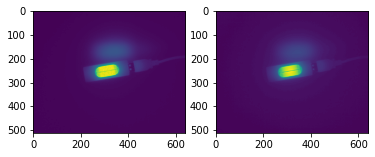

In [41]:
def kel_to_c(img):
    return img - 273.15
# kel_to_c = lambda img: img - 273.15

imgc = kel_to_c(tlin_to_temp(img))
imgc = np.array(imgc, dtype=np.uint8)

img_filterc = kel_to_c(tlin_to_temp(img_filter))
img_filterc = np.array(img_filterc, dtype=np.uint8)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(imgc)
ax[1].imshow(img_filterc)

# np.max(img_filterc)

## Vykreslete graf závislosti transmisivity atmosféry na vzdálenosti a na vlhkosti

Použijte funkci atmospheric_transmisivity.

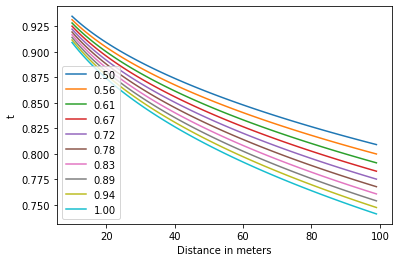

In [72]:
# TODO: implement
tl = np.linspace(0.001, 1, 100)
temp = [kel_to_c(tlin_to_temp(i)) for i in tl]
temp =  np.linspace(0, 100, 100)
dist = [i for i in range(10, 100)]

# print(temp)

humidity = np.linspace(0.5, 1, 10)

val = np.zeros((len(humidity), len(dist)))

for i, h in enumerate(humidity):
#     for i, t in enumerate(temp):
    for j, d in enumerate(dist):
        val[i, j] = atmospheric_transmissivity(23, h, d)

for i, h in enumerate(humidity):
    plt.plot(dist, val[i], label=f"{h:.2f}")

plt.xlabel('Distance in meters')
plt.ylabel('t')
plt.legend()

## Změřte propustnost folie

Naimplementujte funkce, které budou sloužit na výpočet `obj_flux` a `scene_flux`.
Dále změřte propustnost filtru na objektivu a vytvořte model, který bude kompenzovat vliv filtru na výsledných snímcích.

In [7]:
sensor_params = SensorParameters()

class RadiometricModel:
    obj_trans = 0  # zanedbáváme
    atm_reflex = 0  # zanedbáváme
    win_emis = 0  # zanedbáváme

    def __init__(self, *, obj_emis=0.95, bkg_temp=293.15,
            atm_temp=293.15, atm_trans=0.95, 
            win_temp=293.15, win_trans=0.95):
        
        # object
        self.obj_emis = obj_emis
        self.obj_reflex = 1 - obj_emis

        # background
        self.bkg_temp = bkg_temp

        # atmosphere
        self.atm_temp = atm_temp  
        self.atm_trans = atm_trans
        self.atm_emis = 1 - atm_trans

        # window
        self.win_temp = win_temp
        self.win_trans = win_trans
        self.win_reflex = 1 - win_trans

In [75]:
def obj_flux_to_scene_flux_filter(model: RadiometricModel, obj_flux):
    f1 = model.obj_emis * obj_flux + model.obj_reflex * temp_to_flux(model.bkg_temp)
    f2 = f1 * model.atm_trans + temp_to_flux(model.atm_temp) * model.atm_emis
    f3 = f2 * model.win_trans + temp_to_flux(model.win_temp) * model.win_reflex
    return f3

def scene_flux_to_obj_flux_filter(model: RadiometricModel, scene_flux):
    f3 = scene_flux
    f2 = (f3 - temp_to_flux(model.win_temp) * model.win_reflex) / model.win_trans
    f1 = (f2 - temp_to_flux(model.atm_temp) * model.atm_emis) / model.atm_trans
    obj_flux = (f1 - model.obj_reflex * temp_to_flux(model.bkg_temp)) / model.obj_emis
    return obj_flux

def obj_flux_to_scene_flux(model: RadiometricModel, obj_flux):
    f1 = model.obj_emis * obj_flux + model.obj_reflex * temp_to_flux(model.bkg_temp)
    f2 = f1 * model.atm_trans + temp_to_flux(model.atm_temp) * model.atm_emis
#     f3 = f2 * model.win_trans + temp_to_flux(model.win_temp) * model.win_reflex
    return f2

def scene_flux_to_obj_flux(model: RadiometricModel, scene_flux):
#     f3 = scene_flux
#     f2 = (f3 - temp_to_flux(model.win_temp) * model.win_reflex) / model.win_trans
    f2 = scene_flux
    f1 = (f2 - temp_to_flux(model.atm_temp) * model.atm_emis) / model.atm_trans
    obj_flux = (f1 - model.obj_reflex * temp_to_flux(model.bkg_temp)) / model.obj_emis
    return obj_flux

In [76]:
# TODO: implement 
def delete_filter(model: RadiometricModel, scene_flux):
    obj_flux = scene_flux_to_obj_flux_filter(model, scene_flux)
    return obj_flux_to_scene_flux(model, obj_flux)

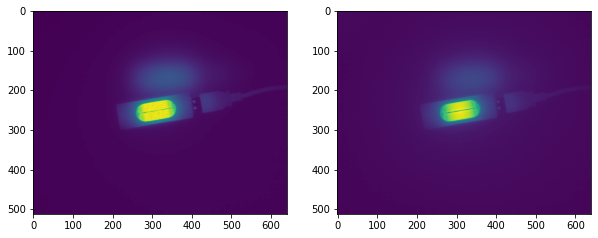

In [87]:
img_del_filter = delete_filter(RadiometricModel(), img_filter)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(img)
ax[1].imshow(img_del_filter)